# Testing your model

After trainning your model, it is time to test it. Be sure your test data, is serilized.

In [1]:
import tensorflow as tf
import pickle
from tensorflow.keras.models import load_model
from keras.initializers import glorot_uniform
import os
import datetime
import re
import numpy as np
from tensorflow.keras.models import load_model
from keras.initializers import glorot_uniform
import numpy as np

Using TensorFlow backend.


In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
now_datetime  = datetime.datetime.now()
NAME = f"#Results_{now_datetime.day:02d}{now_datetime.month:02d}{now_datetime.year}_{now_datetime.hour:02d}{now_datetime.minute:02d}"


In [3]:
if __name__ =="__main__":
    #directory containing the serilized databases, that has the test folder in it
    dir_pickle = "database_serialized"

    #directory for storing the results of the experiments
    dir_results = "results"

    #where to find the models

    dir_models_save = "models"

    #batch size for evaluation and predictions
    batch_size = 3
    #List of people to be ignored, if you alrady have data about them
    ignore_people = []
    #people_to_show = ["001","002","065"]

    format1 = [[80,140,320],[80,140,320]]
    format1_str = ''.join(map(str,format1))
    format2 = [[400,300,200],[400,300,200]]
    format2_str = ''.join(map(str,format2))
    format3 = [[80,120,300],[400]]
    format3_str = ''.join(map(str,format3))

    evaluate_shapes = [format1_str,format2_str,format3_str]
    evaluate_shapes

In [4]:
#Clear memory
from keras.backend import clear_session
clear_session()

In [5]:
def evaluete_model(person,model_name,Xtest,ytest, my_file,shape,show_examples=False):
    #Normalize data
    Xtest_norm = Xtest.astype(np.float16)/255.0
    #Evaluetes the model base on the test
    custom_objects={'GlorotUniform': glorot_uniform()}
    saved_model = load_model(os.path.join(dir_models_save,person,model_name),custom_objects)
    results = saved_model.evaluate(Xtest_norm,ytest,batch_size=batch_size)
    if show_examples:
        predict_random(Xtest,ytest,saved_model,Xtest_norm)
    
    person = re.findall("\d+#",model_name)
    my_file.write(f"Model of shape: {shape}\n\
        \t->Acc= {results[1]}\n")
    return results

In [15]:
def predict_random(Xtest,ytest,saved_model,Xtest_norm):
    import matplotlib.pyplot as plt
    import cv2
    %matplotlib inline
    a = saved_model.predict(Xtest_norm,batch_size=batch_size)
    plt.figure(figsize=(10,10))
    a_round = np.round(a)
    nrows = 4
    ncols = 4
    start = 25
    Xtest_sample = Xtest[start:start +nrows*ncols]
    i = start
    for img in Xtest_sample:
        plt.subplot(nrows,ncols,i-start+1)
        plt.axis("off")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Pred:[{int(a_round[i])}] | Real:({ytest[i]})")
        i += 1
    plt.show()

In [7]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow
import gc
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

In [8]:
if __name__ =="__main__":
    #Calculates the mean
    mean_count_dict = {}
    #Keep track of all scores, to calculate standart deviation
    scores_array_dict = {}
    for shape in evaluate_shapes:
        #str_shape = ''.join(map(str,shape))   
        #Count how many examples there are
        mean_count_dict[shape] = 0
        #Create a empty list, where all the scores of each model will be stored
        scores_array_dict[shape]  = []
        
    people = os.listdir(dir_models_save)
    my_file = open(os.path.join(dir_results,f"{NAME}.txt") ,"w")
    for person in people:
        if person in ignore_people:
            print(f"Ignoring {person}...")
            continue
                
        #Loads The test of the respective person
        print(f"Evaluating: {person}")       
        pickle_in = open(os.path.join(dir_pickle,person,f"X{person}Test.pickle"),"rb")
        Xtest = pickle.load(pickle_in)
        pickle_in.close()
        pickle_in = open(os.path.join(dir_pickle,person,f"y{person}Test.pickle"),"rb")
        ytest = pickle.load(pickle_in)
        pickle_in.close()
        models = os.listdir(os.path.join(dir_models_save,person))
        my_file.write(f"=======================================Results of person: {person}=================================================\n")
        my_file.write(f"Test examples: {len(ytest)}")
        for model in models:
            shape = re.findall("[\[](?:(?:\s*\d+,*\s*)+\d+\s*)[\]]",model)
            shape = ''.join(map(str,shape))
            print(shape)
            if shape in evaluate_shapes:
                print(f"\t->Evaluating {model};")
                results = evaluete_model(person,model,Xtest,ytest,my_file,shape,show_examples=False)
                mean_count_dict[shape] += 1
                scores_array_dict[shape].append(results[1])
                reset_keras()
            else:
                continue
        del Xtest,ytest

            
        my_file.write("\n=============================================END================================================================\n")
        my_file.flush()
        
    #kills the kernel to free-up memory on GPU, also avoiding collisions with othhers scripts bb
    #comment the line below, if you want to keep the variables and buffers

Evaluating: 001
[400, 300, 200][400, 300, 200]
	->Evaluating 001#Face_spoofing300x2_13102019_2219[400, 300, 200][400, 300, 200].h5;
1153/1153 [==============================] - 29s 25ms/sample - loss: 0.5556 - acc: 0.8977
75478
[80, 140, 320][80, 140, 320]
	->Evaluating 001#Face_spoofing300x2_13102019_2219[80, 140, 320][80, 140, 320].h5;
1153/1153 [==============================] - 7s 6ms/sample - loss: 0.0521 - acc: 1.0000
75493
[80, 120, 300][400]
	->Evaluating 001#Face_spoofing300x2_16102019_1727[80, 120, 300][400].h5;
1153/1153 [==============================] - 7s 6ms/sample - loss: 0.0709 - acc: 0.9922
52093
Evaluating: 002
[400, 300, 200][400, 300, 200]
	->Evaluating 002#Face_spoofing300x2_14102019_0215[400, 300, 200][400, 300, 200].h5;
1136/1136 [==============================] - 27s 24ms/sample - loss: 0.7113 - acc: 0.9745
75493
[80, 140, 320][80, 140, 320]
	->Evaluating 002#Face_spoofing300x2_14102019_0215[80, 140, 320][80, 140, 320].h5;
1136/1136 [===========================

991/991 [==============================] - 21s 21ms/sample - loss: 0.6527 - acc: 0.7719
75493
[80, 120, 300][400]
	->Evaluating 020#Face_spoofing300x2_16102019_1727[80, 120, 300][400].h5;
991/991 [==============================] - 7s 7ms/sample - loss: 0.7957 - acc: 0.8587
52093
Evaluating: 021
[400, 300, 200][400, 300, 200]
	->Evaluating 021#Face_spoofing300x2_15102019_1714[400, 300, 200][400, 300, 200].h5;
482/482 [==============================] - 13s 27ms/sample - loss: 35.3972 - acc: 0.7573
75484
[80, 140, 320][80, 140, 320]
	->Evaluating 021#Face_spoofing300x2_15102019_1714[80, 140, 320][80, 140, 320].h5;
482/482 [==============================] - 12s 25ms/sample - loss: 0.2222 - acc: 0.9627
75484
[80, 120, 300][400]
	->Evaluating 021#Face_spoofing300x2_16102019_1727[80, 120, 300][400].h5;
482/482 [==============================] - 4s 7ms/sample - loss: 0.6827 - acc: 0.8838
52084
Evaluating: 023
[400, 300, 200][400, 300, 200]
	->Evaluating 023#Face_spoofing300x2_15102019_1714[400

491/491 [==============================] - 6s 13ms/sample - loss: 0.1102 - acc: 0.9939
52084
Evaluating: 048
[400, 300, 200][400, 300, 200]
	->Evaluating 048#Face_spoofing300x2_15102019_1714[400, 300, 200][400, 300, 200].h5;
479/479 [==============================] - 42s 87ms/sample - loss: 0.0799 - acc: 1.0000
75484
[80, 140, 320][80, 140, 320]
	->Evaluating 048#Face_spoofing300x2_15102019_1714[80, 140, 320][80, 140, 320].h5;
479/479 [==============================] - 5s 10ms/sample - loss: 0.6074 - acc: 0.9937
75484
[80, 120, 300][400]
	->Evaluating 048#Face_spoofing300x2_16102019_1727[80, 120, 300][400].h5;
479/479 [==============================] - 3s 7ms/sample - loss: 0.0220 - acc: 1.0000
52084
Evaluating: 049
[400, 300, 200][400, 300, 200]
	->Evaluating 049#Face_spoofing300x2_15102019_1714[400, 300, 200][400, 300, 200].h5;
590/590 [==============================] - 18s 31ms/sample - loss: 0.1395 - acc: 0.9898
75484
[80, 140, 320][80, 140, 320]
	->Evaluating 049#Face_spoofing300x

518/518 [==============================] - 5s 10ms/sample - loss: 0.2162 - acc: 0.9942
75484
[80, 120, 300][400]
	->Evaluating 071#Face_spoofing300x2_16102019_1727[80, 120, 300][400].h5;
518/518 [==============================] - 7s 13ms/sample - loss: 0.0643 - acc: 0.9942
52084
Evaluating: 073
[400, 300, 200][400, 300, 200]
	->Evaluating 073#Face_spoofing300x2_16102019_1241[400, 300, 200][400, 300, 200].h5;
537/537 [==============================] - 16s 31ms/sample - loss: 0.3707 - acc: 0.9944
75484
[80, 140, 320][80, 140, 320]
	->Evaluating 073#Face_spoofing300x2_16102019_1241[80, 140, 320][80, 140, 320].h5;
537/537 [==============================] - 5s 9ms/sample - loss: 0.1261 - acc: 0.9944
75484
[80, 120, 300][400]
	->Evaluating 073#Face_spoofing300x2_16102019_1727[80, 120, 300][400].h5;
537/537 [==============================] - 8s 14ms/sample - loss: 0.0487 - acc: 0.9944
52084
Evaluating: 075
[400, 300, 200][400, 300, 200]
	->Evaluating 075#Face_spoofing300x2_16102019_1241[400, 

In [9]:
if __name__ =="__main__":
    s_mean = {}
    std_dev  = {}
    my_file.write("\n========================================CALCULATIONS============================================================\n")
    for shape in evaluate_shapes:
        np_array = np.array(scores_array_dict[shape])
        
        s_mean[shape] = np.mean(np_array)
        std_dev[shape] = np.sum(np.power(np_array-s_mean[shape],2))/mean_count_dict[shape]
        std_dev[shape] = np.sqrt(std_dev[shape])
        
        my_file.write(f"{shape}\n")
        my_file.write(f"Mean                :{s_mean[shape]}\n"\
                        f"Standart Deviation:{std_dev[shape]}\n"\
                        f"Number of models  :{mean_count_dict[shape]}\n"\
                        "---------------------------------------------\n")
    print("End of the evaluation of all models")
    my_file.close()

End of the evaluation of all models


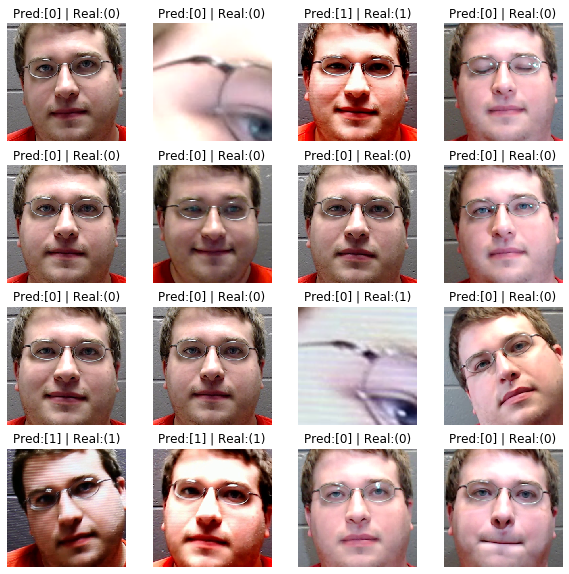

In [16]:
if __name__ == "__main__":
    custom_objects={'GlorotUniform': glorot_uniform()}
    person = "018"
    model_p = load_model("models\\018\\018#Face_spoofing300x2_16102019_1727[80, 120, 300][400].h5",custom_objects)
    pickle_in = open(os.path.join(dir_pickle,person,f"X{person}Test.pickle"),"rb")
    Xtest = pickle.load(pickle_in)
    pickle_in.close()
    pickle_in = open(os.path.join(dir_pickle,person,f"y{person}Test.pickle"),"rb")
    ytest = pickle.load(pickle_in)
    pickle_in.close()
    Xtest_norm = Xtest.astype(np.float16)/255
    predict_random(Xtest,ytest,model_p,Xtest_norm)
    

In [ ]:
if __name__ =="__main__":
    os._exit(00)